In [34]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import torch.nn.functional as F
#from torchsummary import summary
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import time
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


Loading the dataset

In [24]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), #converting the images to grayscale for computation
    transforms.Resize((28, 28)),  # Resize images if necessary
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Convert images to PyTorch tensors
])

In [25]:
dataset = ImageFolder(root='/Users/mogankumarnarsozhan/Documents/VSCODE/cnn_dataset', transform=transform)

Splitting the dataset into training, validation and testing sets

In [26]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

In [27]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'validation samples: {len(val_dataset)}')
print(f'Testing samples: {len(test_dataset)}')

Training samples: 80640
validation samples: 10080
Testing samples: 10080


In [28]:
num_classes = len(dataset.classes)
print(f'Number of classes: {num_classes}')
print(f'Class names: {dataset.classes}')

Number of classes: 36
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


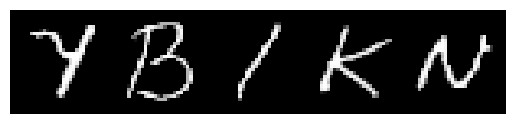

In [29]:
def show_images(images):
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))

show_images(images[:5])

Finding the class distribution of the dataset

In [33]:
from collections import Counter

labels = [label for _, label in dataset]
label_counts = Counter(labels)

print("Class Distribution:")
for digit, count in sorted(label_counts.items()):
    print(f"Digit {digit}: {count}")


Class Distribution:
Digit 0: 2800
Digit 1: 2800
Digit 2: 2800
Digit 3: 2800
Digit 4: 2800
Digit 5: 2800
Digit 6: 2800
Digit 7: 2800
Digit 8: 2800
Digit 9: 2800
Digit 10: 2800
Digit 11: 2800
Digit 12: 2800
Digit 13: 2800
Digit 14: 2800
Digit 15: 2800
Digit 16: 2800
Digit 17: 2800
Digit 18: 2800
Digit 19: 2800
Digit 20: 2800
Digit 21: 2800
Digit 22: 2800
Digit 23: 2800
Digit 24: 2800
Digit 25: 2800
Digit 26: 2800
Digit 27: 2800
Digit 28: 2800
Digit 29: 2800
Digit 30: 2800
Digit 31: 2800
Digit 32: 2800
Digit 33: 2800
Digit 34: 2800
Digit 35: 2800


In [9]:
num_classes = 36
batch_size = 32
learning_rate = 0.001
num_epochs = 3

**Base Model**

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        # x = self.fc2(x)
        # x = F.softmax(x, dim=1)
        x = F.relu(self.fc2(x))
        return x

In [11]:
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training and validation of the dataset

In [12]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += loss_function(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/3], Train Loss: 1.5060, Train Accuracy: 58.91%, Validation Loss: 0.6872, Validation Accuracy: 79.50%
Epoch [2/3], Train Loss: 0.8462, Train Accuracy: 74.27%, Validation Loss: 0.5293, Validation Accuracy: 83.07%
Epoch [3/3], Train Loss: 0.6567, Train Accuracy: 79.02%, Validation Loss: 0.4051, Validation Accuracy: 86.33%


Testing the dataset

In [13]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {test_accuracy:.2f}%')


Accuracy on the test set: 86.16%


Plotting accuracy and loss graph for the base model

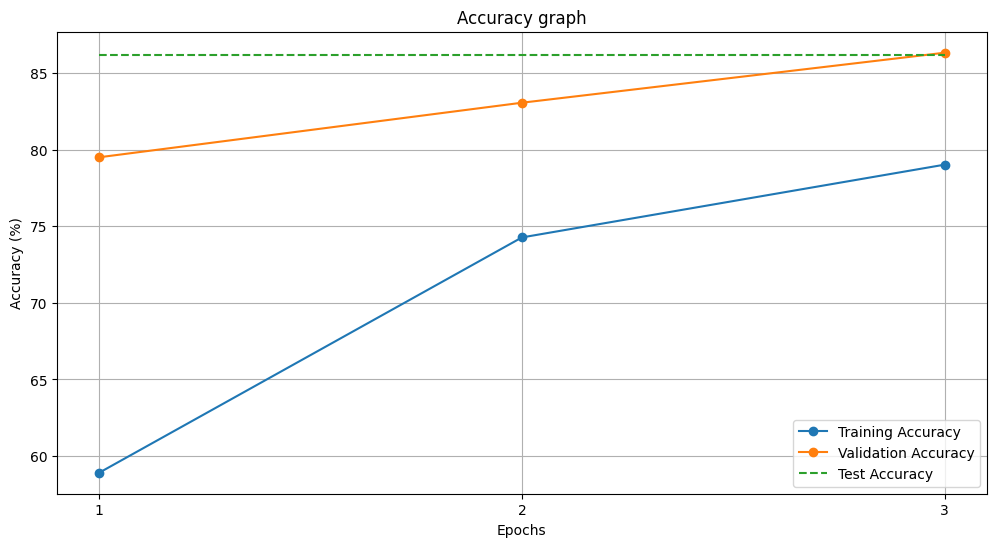

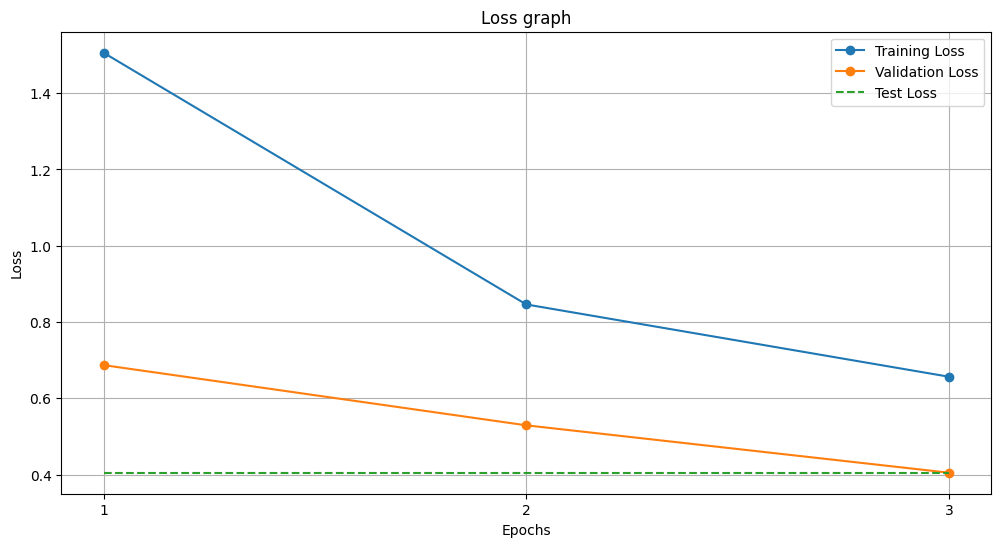

In [14]:
test_accuracy_line = [test_accuracy] * num_epochs
test_loss_line = [val_losses[-1]] * num_epochs

##ACCURACY GRAPH##
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracy_line, label='Test Accuracy', linestyle='--')
plt.title('Accuracy graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.show()

##LOSS GRAPH##
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_loss_line, label='Test Loss', linestyle='--')
plt.title('Loss graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.show()

**Improving the model by EARLYSTOPPING METHOD**

In [15]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(root='/Users/mogankumarnarsozhan/Documents/VSCODE/cnn_dataset', transform=transform)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Use test set as validation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(dataset.classes)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return x

class EarlyStopping:
    def __init__(self, patience=2, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

num_epochs = 10
learning_rate = 0.001

model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=2, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#TRAINING LOOP
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #VALIDATION LOOP
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    #EARLY STOPPING
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Training stopped early.")
        break

########TESTING#########
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {test_accuracy:.2f}%')

Epoch 1/10, Train Loss: 1.2123, Train Accuracy: 65.89%, Validation Loss: 0.4714, Validation Accuracy: 84.99%
Epoch 2/10, Train Loss: 0.5930, Train Accuracy: 80.57%, Validation Loss: 0.3183, Validation Accuracy: 88.84%
Epoch 3/10, Train Loss: 0.4869, Train Accuracy: 83.42%, Validation Loss: 0.3090, Validation Accuracy: 88.77%
Epoch 4/10, Train Loss: 0.4433, Train Accuracy: 84.82%, Validation Loss: 0.2815, Validation Accuracy: 89.57%
Epoch 5/10, Train Loss: 0.4087, Train Accuracy: 85.87%, Validation Loss: 0.2822, Validation Accuracy: 89.86%
Epoch 6/10, Train Loss: 0.3854, Train Accuracy: 86.62%, Validation Loss: 0.2779, Validation Accuracy: 89.99%
Epoch 7/10, Train Loss: 0.3623, Train Accuracy: 87.23%, Validation Loss: 0.2730, Validation Accuracy: 90.74%
Epoch 8/10, Train Loss: 0.3450, Train Accuracy: 87.70%, Validation Loss: 0.2716, Validation Accuracy: 90.59%
Epoch 9/10, Train Loss: 0.3355, Train Accuracy: 88.01%, Validation Loss: 0.2723, Validation Accuracy: 90.62%
Epoch 10/10, Train 

Plotting the accuracy and loss graph for **Base model + Early stopping technique**

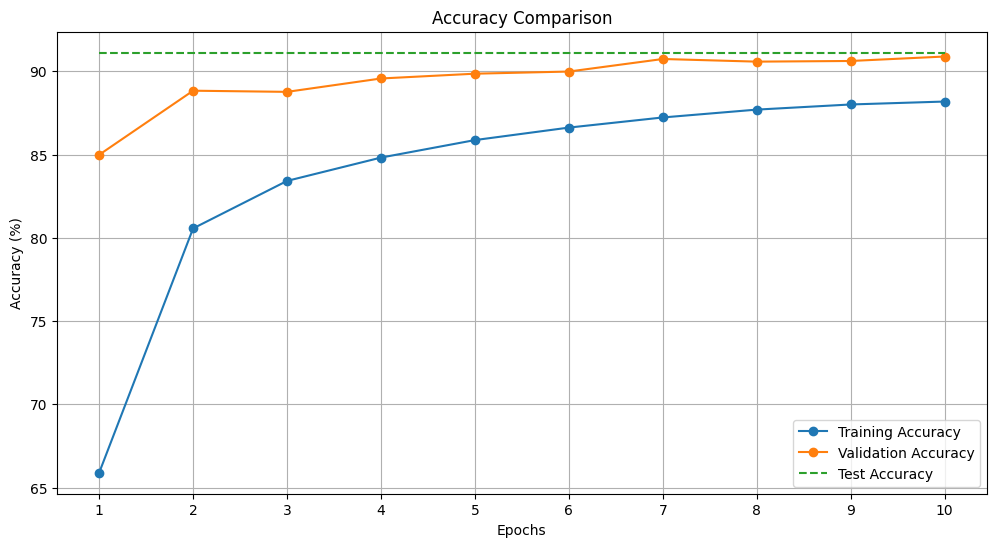

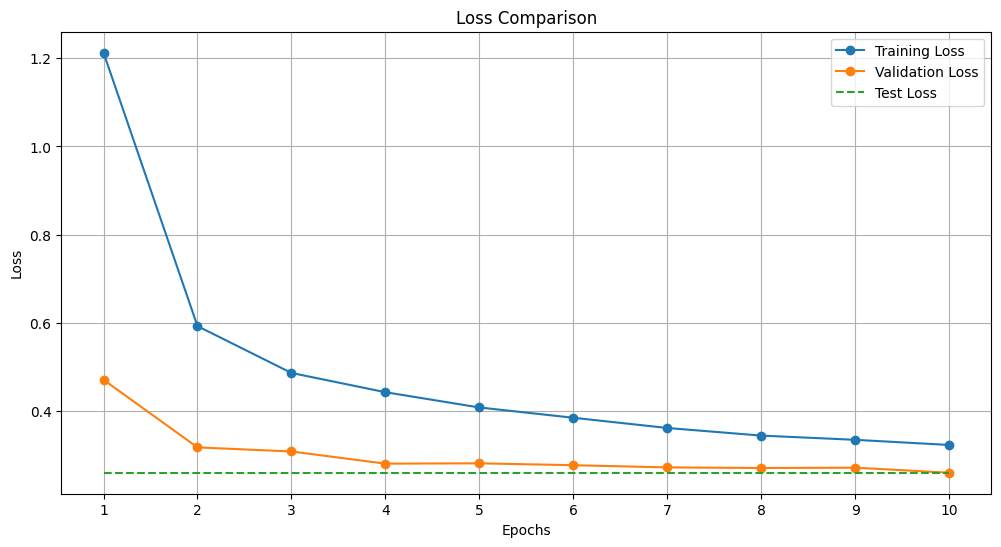

In [16]:
test_accuracy_line = [test_accuracy] * len(val_accuracies)
test_loss_line = [val_losses[-1]] * len(val_losses)

#ACCURACY GRAPH##
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(range(1, len(test_accuracy_line) + 1), test_accuracy_line, label='Test Accuracy', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.show()

##LOSS GRAPH##
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.plot(range(1, len(test_loss_line) + 1), test_loss_line, label='Test Loss', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.show()

**Implementing K-Fold technique**

FOLD 1/3
---------------------------
Epoch [1/3], Loss: 1.9772, Validation Accuracy: 68.44%
Epoch [2/3], Loss: 1.3230, Validation Accuracy: 74.38%
Epoch [3/3], Loss: 1.0881, Validation Accuracy: 77.67%
FOLD 2/3
---------------------------
Epoch [1/3], Loss: 1.5741, Validation Accuracy: 79.49%
Epoch [2/3], Loss: 0.8980, Validation Accuracy: 84.85%
Epoch [3/3], Loss: 0.7013, Validation Accuracy: 87.76%
FOLD 3/3
---------------------------
Epoch [1/3], Loss: 1.6523, Validation Accuracy: 77.71%
Epoch [2/3], Loss: 1.0567, Validation Accuracy: 81.57%
Epoch [3/3], Loss: 0.8965, Validation Accuracy: 82.29%
Average Validation Accuracy over 3 folds: 82.58%
Test Accuracy on the test set: 81.71%


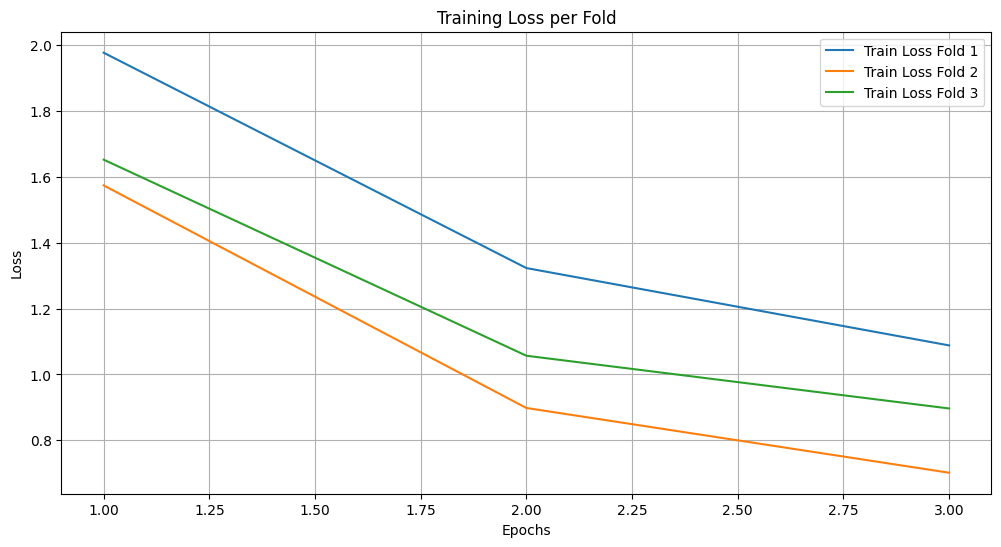

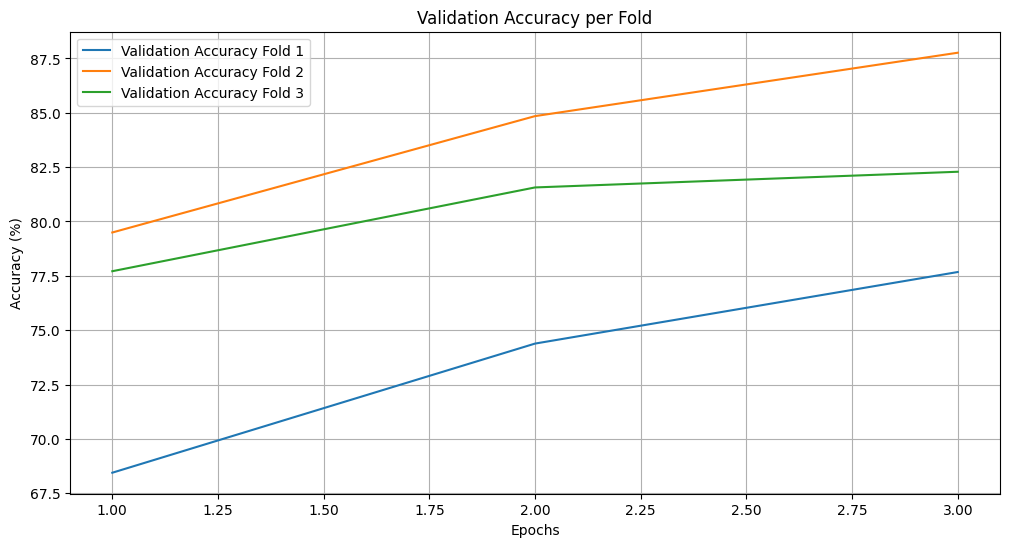

In [17]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(root='/Users/mogankumarnarsozhan/Documents/VSCODE/cnn_dataset', transform=transform)
num_classes = len(dataset.classes)

batch_size = 32
learning_rate = 0.001
num_epochs = 3
k_folds = 3

#THIS IS MY BASE CNN MODEL
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return x

train_val_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_val_size
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

kfold = KFold(n_splits=k_folds, shuffle=True)
results = []

all_train_losses = []
all_val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_val_dataset)):
    print(f'FOLD {fold+1}/{k_folds}')
    print('---------------------------')

    train_subset = Subset(train_val_dataset, train_idx)
    val_subset = Subset(train_val_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = CNN()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    #TRAINING LOOP
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        #VALIDATION LOOP
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    all_train_losses.append(train_losses)
    all_val_accuracies.append(val_accuracies)
    results.append(val_accuracy)

avg_accuracy = np.mean(results)
print(f'Average Validation Accuracy over {k_folds} folds: {avg_accuracy:.2f}%')

#TESTING LOOP
model.eval()
test_correct = 0
test_total = 0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy on the test set: {test_accuracy:.2f}%')

epochs = range(1, num_epochs + 1)

#LOSS GRAPH
plt.figure(figsize=(12, 6))
for fold in range(k_folds):
    plt.plot(epochs, all_train_losses[fold], label=f'Train Loss Fold {fold+1}')
plt.title('Training Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#ACCURACY GRAPH
plt.figure(figsize=(12, 6))
for fold in range(k_folds):
    plt.plot(epochs, all_val_accuracies[fold], label=f'Validation Accuracy Fold {fold+1}')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()


**Implementing BATCH NORMALIZATION technique**

In [18]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(root='/Users/mogankumarnarsozhan/Documents/VSCODE/cnn_dataset', transform=transform)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = 36
learning_rate = 0.001
num_epochs = 3

# My base CNN model with batch normalization
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc_bn1(self.fc1(x))))
        x = F.relu(self.fc2(x))
        return x

model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
best_model_path = '/Users/mogankumarnarsozhan/Documents/VSCODE/mogankum_assignment2_part_3.pt'

#TRAINING LOOP
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()  
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    #VALIDATION LOOP 
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += loss_function(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_duration = end_time - start_time

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: Best validation loss updated ({best_val_loss:.4f})")

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

#TESTING LOOP
model.eval()

all_preds = []
all_labels = []
all_probs = [] 

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {test_accuracy:.2f}%')


Epoch 1: Best validation loss updated (0.2919)
Epoch [1/3], Train Loss: 0.7581, Train Accuracy: 78.61%, Validation Loss: 0.2919, Validation Accuracy: 89.85%
Epoch 2: Best validation loss updated (0.2679)
Epoch [2/3], Train Loss: 0.3955, Train Accuracy: 86.42%, Validation Loss: 0.2679, Validation Accuracy: 90.17%
Epoch 3: Best validation loss updated (0.2483)
Epoch [3/3], Train Loss: 0.3458, Train Accuracy: 87.77%, Validation Loss: 0.2483, Validation Accuracy: 91.06%
Accuracy on the test set: 90.57%


Confusion matrix

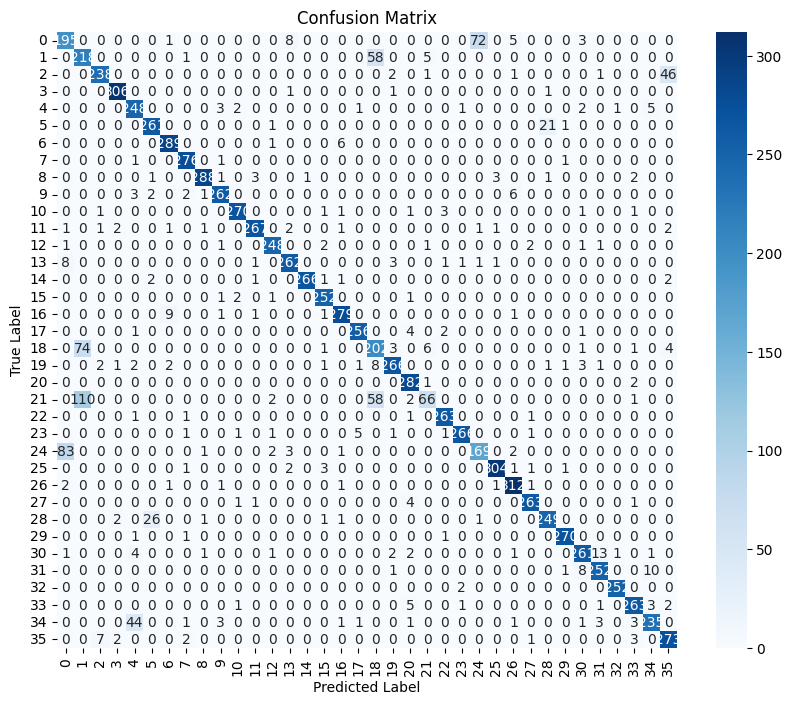

In [19]:
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Plotting the accuracy and loss graph

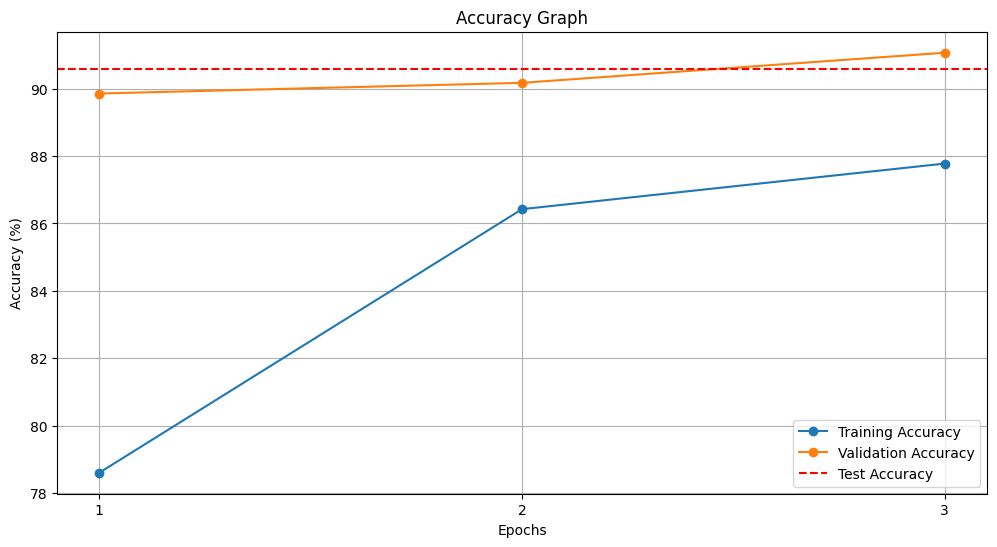

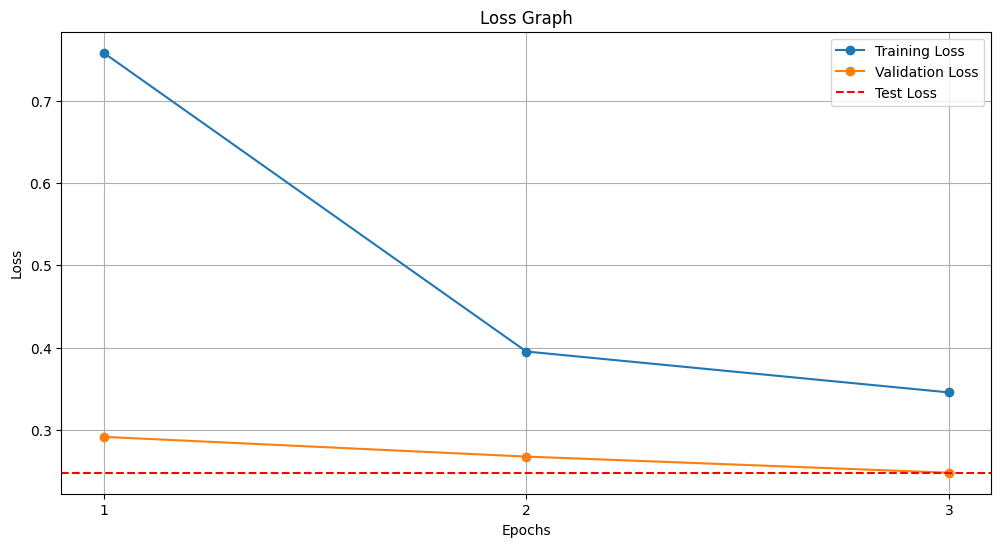

In [20]:
#ACCURACY GRAPH
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.axhline(y=test_accuracy, label='Test Accuracy', linestyle='--', color='red')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.show()

#LOSS GRAPH
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.axhline(y=val_losses[-1], label='Test Loss', linestyle='--', color='red')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.show()

Plotting the ROC curve

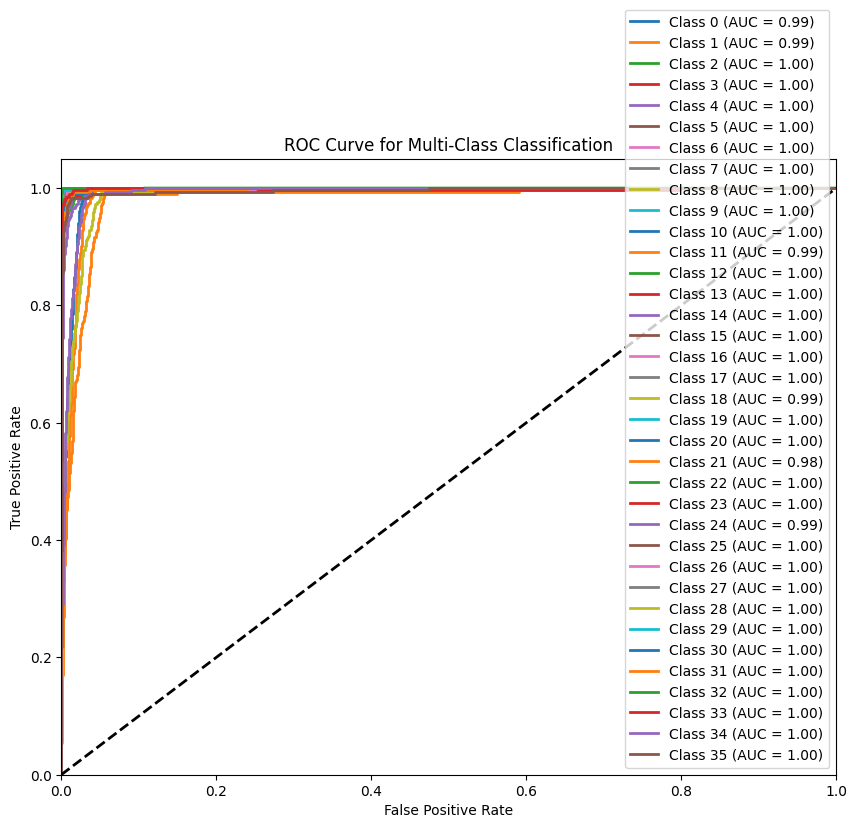

In [21]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.vstack(all_probs)

num_classes = 36
binarized_labels = label_binarize(all_labels, classes=np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()